In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
dataT = pd.read_csv("C:/Users/wxiny/Desktop/Walmart-Store-Sales-Forecasting/data/sales_train_validation.csv")
dataE = pd.read_csv("C:/Users/wxiny/Desktop/Walmart-Store-Sales-Forecasting/data/sales_train_evaluation.csv")
Calendar = pd.read_csv("C:/Users/wxiny/Desktop/Walmart-Store-Sales-Forecasting/data/calendar.csv")
sellprice = pd.read_csv("C:/Users/wxiny/Desktop/Walmart-Store-Sales-Forecasting/data/sell_prices.csv")


In [3]:
dataE.shape

(30490, 1947)

In [4]:
dataT.shape

(30490, 1919)

In [5]:
dataE[['dept', 'item', 'store', 'dataset_type']] = dataE['id'].str.split('_', n=3, expand=True)
hobbies_1_train = dataE[dataE['dept_id'] == 'HOBBIES_1']
hobbies_1_train = hobbies_1_train.melt(
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d', 
    value_name='sales'
)
hobbies_1_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [6]:
merged_df = hobbies_1_train.merge(Calendar, on='d', how='left')
time_series_data = merged_df.groupby('date')['sales'].sum().reset_index()
time_series_data_with_event=time_series_data.merge(Calendar,on='date',how='left')
time_series_data_with_event=time_series_data_with_event[['date','sales','weekday','event_name_1','event_type_1','event_name_2','snap_CA','snap_TX','snap_WI']]
time_series_data_with_event

,date,sales,weekday,event_name_1,event_type_1,event_name_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,3610,Saturday,NaN,NaN,NaN,0,0,0
1,2011-01-30,3172,Sunday,NaN,NaN,NaN,0,0,0
2,2011-01-31,2497,Monday,NaN,NaN,NaN,0,0,0
3,2011-02-01,2531,Tuesday,NaN,NaN,NaN,1,1,0
4,2011-02-02,1714,Wednesday,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,3291,Wednesday,NaN,NaN,NaN,0,0,0
1937,2016-05-19,3027,Thursday,NaN,NaN,NaN,0,0,0
1938,2016-05-20,3761,Friday,NaN,NaN,NaN,0,0,0
1939,2016-05-21,4832,Saturday,NaN,NaN,NaN,0,0,0


In [7]:
time_series_data_with_event['date'] = pd.to_datetime(time_series_data_with_event['date'])
time_series_data_with_event.set_index('date', inplace=True)
"""
label_enc = LabelEncoder()

time_series_data_with_event['event_name_1'].fillna('NoEvent', inplace=True)
time_series_data_with_event['event_name_1'] = label_enc.fit_transform(time_series_data_with_event['event_name_1'])
time_series_data_with_event['event_type_1'].fillna('No', inplace=True)
time_series_data_with_event['event_type_1'] = label_enc.fit_transform(time_series_data_with_event['event_type_1'])
"""

"\nlabel_enc = LabelEncoder()\n\ntime_series_data_with_event['event_name_1'].fillna('NoEvent', inplace=True)\ntime_series_data_with_event['event_name_1'] = label_enc.fit_transform(time_series_data_with_event['event_name_1'])\ntime_series_data_with_event['event_type_1'].fillna('No', inplace=True)\ntime_series_data_with_event['event_type_1'] = label_enc.fit_transform(time_series_data_with_event['event_type_1'])\n"

In [8]:
full_date_range = pd.date_range(start=time_series_data_with_event.index.min(),
                                end=time_series_data_with_event.index.max(),
                                freq='D')

# Identify missing dates by comparing the full date range to your DataFrame's index
missing_dates = full_date_range.difference(time_series_data_with_event.index)

# Display the missing dates, if any
if missing_dates.empty:
    print("No missing dates in the time series.")
else:
    print("Missing dates in the time series:")
    print(missing_dates)

No missing dates in the time series.


In [9]:
time_series_data_with_event['sales']=time_series_data_with_event['sales'].astype(int)

time_series_data_with_event['Sales_lag7'] = time_series_data_with_event['sales'].shift(7)
time_series_data_with_event['Sales_rolling_mean_7'] = time_series_data_with_event['sales'].rolling(window=7).mean()
time_series_data_with_event = time_series_data_with_event.fillna({'Sales_lag7': 0, 'Sales_rolling_mean_7': 0})
time_series_data_with_event['is_weekend'] = time_series_data_with_event['weekday'].isin(['Saturday', 'Sunday']).astype(int)
time_series_data_with_event['is_holiday'] = time_series_data_with_event[['event_name_1', 'event_name_2']].notnull().any(axis=1).astype(int)


# Display the first few rows to verify the new column
time_series_data_with_event.head(15)

,sales,weekday,event_name_1,event_type_1,event_name_2,snap_CA,snap_TX,snap_WI,Sales_lag7,Sales_rolling_mean_7,is_weekend,is_holiday
date,,,,,,,,,,,,
2011-01-29,3610,Saturday,NaN,NaN,NaN,0,0,0,0.0,0.000000,1,0
2011-01-30,3172,Sunday,NaN,NaN,NaN,0,0,0,0.0,0.000000,1,0
2011-01-31,2497,Monday,NaN,NaN,NaN,0,0,0,0.0,0.000000,0,0
2011-02-01,2531,Tuesday,NaN,NaN,NaN,1,1,0,0.0,0.000000,0,0
2011-02-02,1714,Wednesday,NaN,NaN,NaN,1,0,1,0.0,0.000000,0,0
2011-02-03,3133,Thursday,NaN,NaN,NaN,1,1,1,0.0,0.000000,0,0
2011-02-04,2855,Friday,NaN,NaN,NaN,1,0,0,0.0,2787.428571,0,0
2011-02-05,3831,Saturday,NaN,NaN,NaN,1,1,1,3610.0,2819.000000,1,0
2011-02-06,2741,Sunday,SuperBowl,Sporting,NaN,1,1,1,3172.0,2757.428571,1,1


In [10]:
train = time_series_data_with_event.loc[:'2016-04-24']
test = time_series_data_with_event.loc['2016-04-25':]

In [11]:
train.head()

,sales,weekday,event_name_1,event_type_1,event_name_2,snap_CA,snap_TX,snap_WI,Sales_lag7,Sales_rolling_mean_7,is_weekend,is_holiday
date,,,,,,,,,,,,
2011-01-29,3610,Saturday,NaN,NaN,NaN,0,0,0,0.0,0.0,1,0
2011-01-30,3172,Sunday,NaN,NaN,NaN,0,0,0,0.0,0.0,1,0
2011-01-31,2497,Monday,NaN,NaN,NaN,0,0,0,0.0,0.0,0,0
2011-02-01,2531,Tuesday,NaN,NaN,NaN,1,1,0,0.0,0.0,0,0
2011-02-02,1714,Wednesday,NaN,NaN,NaN,1,0,1,0.0,0.0,0,0


# Start modeling SARIMAX

In [12]:
exog_vars = ['is_weekend', 'Sales_lag7', 'Sales_rolling_mean_7','is_holiday']
exog_data = train[exog_vars]

In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is NOT stationary. Differencing is needed.")

adf_test(train['sales'])

ADF Statistic: -2.0058081967434505
p-value: 0.28403222863787925
The data is NOT stationary. Differencing is needed.


In [14]:

result = adfuller(train['sales'].diff().dropna()) 
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The first-differenced data is now stationary.")
else:
    print("The first-differenced data is still NOT stationary. Second differencing might be needed.")


ADF Statistic: -14.51300937112465
p-value: 5.683998109306706e-27
The first-differenced data is now stationary.


In [17]:
import statsmodels.api as sm
trainmodel=train[['sales']]
p, d, q = 2, 1, 2
model = sm.tsa.SARIMAX(trainmodel, exog=exog_data, order=(p, d, q), seasonal_order=(1, 1, 2, 7))
model_fit = model.fit()

d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

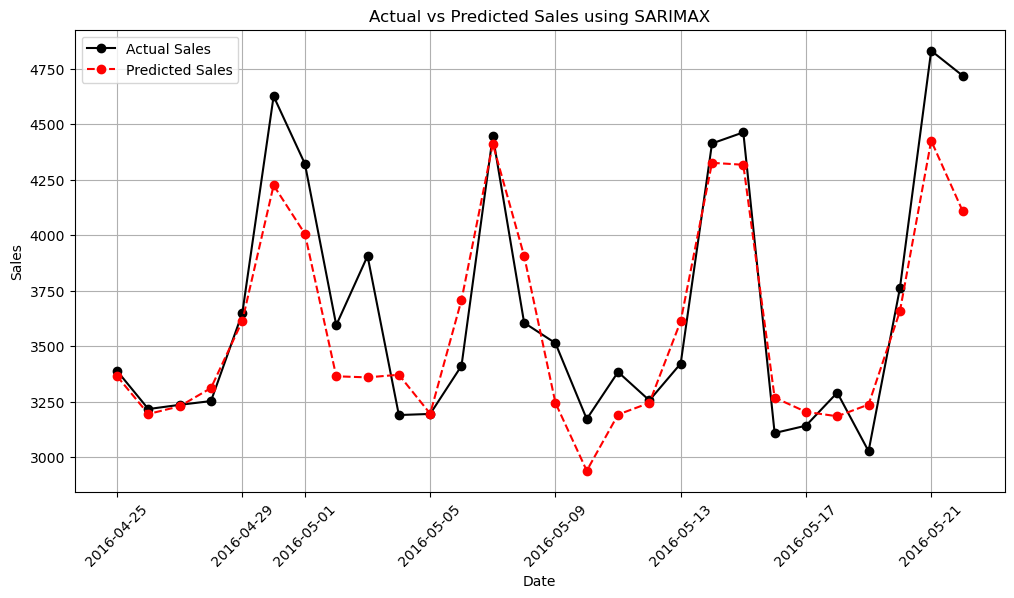

In [19]:
import matplotlib.pyplot as plt

# Define exogenous variables
exog_vars = ['is_weekend', 'Sales_lag7', 'Sales_rolling_mean_7', 'is_holiday']
test_exog = test[exog_vars]

# Forecast using SARIMAX model
forecast = model_fit.get_forecast(steps=28, exog=test_exog)
predicted_sales = forecast.predicted_mean
conf_int = forecast.conf_int()

# Convert sales data to integers safely
test1 = test[['sales']].copy()
test1['sales'] = test1['sales'].astype(int)

# Plot actual vs. predicted sales
plt.figure(figsize=(12, 6))
plt.plot(test.index, test1['sales'], label='Actual Sales', color='#000000', linestyle='-', marker='o')  # Black solid line
plt.plot(test.index, predicted_sales, label='Predicted Sales', color='#FF0000', linestyle='--', marker='o')  # Red dashed line


# Labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales using SARIMAX')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.show()




In [23]:
# Compute Ljung-Box test for residuals
lb_test_results = sm.stats.acorr_ljungbox(model_fit.resid, lags=[1, 2, 3, 4, 5, 6, 7, 10, 14, 20, 28, 30, 60, 90], return_df=True)
lb_test_results


,lb_stat,lb_pvalue
1,3.287477,6.981023e-02
2,7.811161,2.012926e-02
3,8.706573,3.345759e-02
4,9.453830,5.070464e-02
5,11.376236,4.441007e-02
6,45.708056,3.384369e-08
7,45.778444,9.654057e-08
10,50.779297,1.918050e-07
14,85.432831,2.745677e-12
20,106.878271,7.258841e-14


In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse = np.sqrt(mean_squared_error(test['sales'], predicted_sales))
print(f'RMSE: {rmse}')
mae = mean_absolute_error(test['sales'], predicted_sales)
print(f'MAE: {mae:.2f}')
mape = np.mean(np.abs((test['sales'] - predicted_sales) / test['sales'])) * 100
print(f'MAPE: {mape:.2f}%')

RMSE: 245.85045004205412
MAE: 187.30
MAPE: 4.91%
